In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings # Supress warnings 
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib inline

import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error

In [ ]:
df=pd.read_csv('Total_building.csv',parse_dates=True,index_col='Date')

df

In [25]:
df.columns

Index(['z1_Light(kW)', 'z1_Plug(kW)', 'z2_AC1(kW)', 'z2_AC2(kW)', 'z2_AC3(kW)',
       'z2_AC4(kW)', 'z2_Light(kW)', 'z2_Plug(kW)', 'z3_Light(kW)',
       'z3_Plug(kW)', 'z4_Light(kW)', 'z1_AC1(kW)', 'z1_S1(degC)',
       'z1_S1(RH%)', 'z1_S1(lux)', 'z2_AC5(kW)', 'z2_AC6(kW)', 'z2_AC7(kW)',
       'z2_AC8(kW)', 'z2_AC9(kW)', 'z2_AC10(kW)', 'z2_AC11(kW)', 'z2_AC12(kW)',
       'z2_AC13(kW)', 'z2_AC14(kW)', 'z2_S1(degC)', 'z2_S1(RH%)', 'z2_S1(lux)',
       'z3_S1(degC)', 'z3_S1(RH%)', 'z3_S1(lux)', 'z4_AC1(kW)', 'z4_Plug(kW)',
       'z4_S1(degC)', 'z4_S1(RH%)', 'z4_S1(lux)', 'z1_AC2(kW)', 'z1_AC3(kW)',
       'z1_AC4(kW)', 'z5_AC1(kW)', 'z5_Light(kW)', 'z5_Plug(kW)',
       'z5_S1(degC)', 'z5_S1(RH%)', 'z5_S1(lux)', 'z4_AC2(kW)', 'z4_AC3(kW)',
       'z4_AC4(kW)'],
      dtype='object')

In [23]:
df=df.drop('Unnamed: 0.1',axis=1)

In [24]:
df=df.set_index(df['Date'])
df

KeyError: 'Date'

In [8]:
df.index.dtype

dtype('O')

In [64]:
df=df.drop('Unnamed: 0',axis=1)

In [65]:
df['Date']=pd.to_datetime(df['Date'])
df=df.set_index(df['Date'])
df

ValueError: Given date string not likely a datetime.

In [6]:
df.index.dtype

dtype('<M8[ns]')

In [7]:
newdf=pd.DataFrame(columns=['lights','acs','plug'])
newdf

,lights,acs,plug


In [8]:
newdf['lights']=df['z1_Light(kW)']+df['z2_Light(kW)']+df['z3_Light(kW)']+df['z4_Light(kW)']
newdf['acs']=df['z1_AC1(kW)']+df['z2_AC1(kW)']+df['z2_AC2(kW)']+df['z2_AC3(kW)']+df['z2_AC4(kW)']+df['z2_AC5(kW)']+df['z2_AC6(kW)']+df['z2_AC7(kW)']+df['z2_AC8(kW)']+df['z2_AC9(kW)']+df['z2_AC10(kW)']+df['z2_AC11(kW)']+df['z2_AC12(kW)']+df['z2_AC13(kW)']+df['z2_AC14(kW)']+df['z4_AC1(kW)']
newdf['plug']=df['z1_Plug(kW)']+df['z2_Plug(kW)']+df['z3_Plug(kW)']+df['z4_Plug(kW)']

In [9]:
newdf

,lights,acs,plug
Date,,,
2018-07-01 00:00:00,0.02,7.45,0.57
2018-07-01 00:01:00,0.02,7.43,0.57
2018-07-01 00:02:00,0.02,6.19,0.52
2018-07-01 00:03:00,0.02,7.36,0.56
2018-07-01 00:04:00,0.02,7.31,0.56
...,...,...,...
2019-12-31 23:55:00,0.20,7.67,0.49
2019-12-31 23:56:00,0.20,7.71,0.49
2019-12-31 23:57:00,0.20,7.83,0.49


In [10]:
newdf['Power_consumption']=newdf['lights']+newdf['acs']+newdf['plug']
newdf.head(5)

,lights,acs,plug,Power_consumption
Date,,,,
2018-07-01 00:00:00,0.02,7.45,0.57,8.04
2018-07-01 00:01:00,0.02,7.43,0.57,8.02
2018-07-01 00:02:00,0.02,6.19,0.52,6.73
2018-07-01 00:03:00,0.02,7.36,0.56,7.94
2018-07-01 00:04:00,0.02,7.31,0.56,7.89


In [12]:
newdf = newdf.fillna(newdf.mean())

In [14]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    data.drop(col,axis=1,inplace = True)
    return data

In [18]:
def get_lag(data, col, lagtime):
    for i in range(1,lagtime+1):
        if len(pd.Series(col)) == 1:
            data[col+"_lag"+str(i)] = data[col].shift(i*15)
        else:
            for col_j in col:
                data[col_j+"_lag"+str(i)] = data[col_j].shift(i*15)
    return data

In [19]:

newdf['date'] = newdf.index

newdf['hour'] = newdf['date'].dt.hour
newdf = encode(newdf,'hour',24)

newdf['dayofweek'] = newdf['date'].dt.dayofweek
newdf = encode(newdf,'dayofweek',7)

newdf['month'] = newdf['date'].dt.month
newdf = encode(newdf,'month',12)

# newdf['year'] = newdf['date'].dt.year

newdf['dayofyear'] = newdf['date'].dt.dayofyear
newdf = encode(newdf,'dayofyear',365)

newdf['dayofmonth'] = newdf['date'].dt.day
newdf = encode(newdf,'dayofmonth',31)

#newdf['weekofyear'] = newdf['date'].dt.weekofyear

newdf.drop('date',axis=1,inplace = True)

In [20]:
newdf

,lights,acs,plug,Power_consumption,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,dayofyear_sin,dayofyear_cos,dayofmonth_sin,dayofmonth_cos
Date,,,,,,,,,,,,,,
2018-07-01 00:00:00,0.02,7.45,0.57,8.04,0.000000,1.000000,-0.781831,0.62349,-5.000000e-01,-0.866025,8.606997e-03,-0.999963,2.012985e-01,0.97953
2018-07-01 00:01:00,0.02,7.43,0.57,8.02,0.000000,1.000000,-0.781831,0.62349,-5.000000e-01,-0.866025,8.606997e-03,-0.999963,2.012985e-01,0.97953
2018-07-01 00:02:00,0.02,6.19,0.52,6.73,0.000000,1.000000,-0.781831,0.62349,-5.000000e-01,-0.866025,8.606997e-03,-0.999963,2.012985e-01,0.97953
2018-07-01 00:03:00,0.02,7.36,0.56,7.94,0.000000,1.000000,-0.781831,0.62349,-5.000000e-01,-0.866025,8.606997e-03,-0.999963,2.012985e-01,0.97953
2018-07-01 00:04:00,0.02,7.31,0.56,7.89,0.000000,1.000000,-0.781831,0.62349,-5.000000e-01,-0.866025,8.606997e-03,-0.999963,2.012985e-01,0.97953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 23:55:00,0.20,7.67,0.49,8.36,-0.258819,0.965926,0.781831,0.62349,-2.449294e-16,1.000000,6.432491e-16,1.000000,-2.449294e-16,1.00000
2019-12-31 23:56:00,0.20,7.71,0.49,8.40,-0.258819,0.965926,0.781831,0.62349,-2.449294e-16,1.000000,6.432491e-16,1.000000,-2.449294e-16,1.00000
2019-12-31 23:57:00,0.20,7.83,0.49,8.52,-0.258819,0.965926,0.781831,0.62349,-2.449294e-16,1.000000,6.432491e-16,1.000000,-2.449294e-16,1.00000


In [21]:
# adding lagging feature

# adding time lags of 15min,30min as features

lagtime = 2
lag_feature = ['lights','acs', 'plug']
newdf = get_lag(newdf, lag_feature, lagtime)

# adding time lags of 2 hours as features

newdf = get_lag(newdf, 'Power_consumption', 8)

newdf.drop(lag_feature,axis=1,inplace = True)

newdf.dropna(inplace=True)

In [22]:
split_date =pd.to_datetime( '2019-07-31')
df_train = newdf.loc[newdf.index <= split_date].copy()
df_train.shape

(568681, 25)

In [23]:
#df_test = pd.DataFrame(newdf.loc[newdf.index > split_date]
df_test = pd.DataFrame(newdf.loc[newdf.index > split_date])

df_test.shape

(221759, 25)

In [24]:
# The target is forecasting Global_active_power.
X_train, y_train = df_train.iloc[:,1:],df_train.iloc[:,0]
X_test, y_test = df_test.iloc[:,1:],df_test.iloc[:,0]

In [25]:
df_train

,Power_consumption,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,dayofyear_sin,dayofyear_cos,dayofmonth_sin,...,acs_lag2,plug_lag2,Power_consumption_lag1,Power_consumption_lag2,Power_consumption_lag3,Power_consumption_lag4,Power_consumption_lag5,Power_consumption_lag6,Power_consumption_lag7,Power_consumption_lag8
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-01 02:00:00,8.40,0.500000,0.866025,-0.781831,0.623490,-0.5,-0.866025,0.008607,-0.999963,2.012985e-01,...,7.43,0.52,7.87,7.97,6.75,7.79,8.44,7.81,6.66,8.04
2018-07-01 02:01:00,8.29,0.500000,0.866025,-0.781831,0.623490,-0.5,-0.866025,0.008607,-0.999963,2.012985e-01,...,7.45,0.52,8.00,7.99,8.03,7.83,8.42,7.74,8.04,8.02
2018-07-01 02:02:00,8.04,0.500000,0.866025,-0.781831,0.623490,-0.5,-0.866025,0.008607,-0.999963,2.012985e-01,...,7.39,0.54,7.97,7.97,7.93,7.90,8.27,7.68,8.04,6.73
2018-07-01 02:03:00,7.95,0.500000,0.866025,-0.781831,0.623490,-0.5,-0.866025,0.008607,-0.999963,2.012985e-01,...,7.40,0.52,7.94,7.94,7.98,7.98,8.16,7.65,7.98,7.94
2018-07-01 02:04:00,6.76,0.500000,0.866025,-0.781831,0.623490,-0.5,-0.866025,0.008607,-0.999963,2.012985e-01,...,7.38,0.52,7.96,7.94,8.02,6.75,7.95,7.63,7.99,7.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-30 23:56:00,4.55,-0.258819,0.965926,0.781831,0.623490,-0.5,-0.866025,-0.471160,-0.882048,-2.012985e-01,...,3.82,0.75,8.25,4.79,4.62,4.64,4.59,4.61,4.66,4.68
2019-07-30 23:57:00,4.57,-0.258819,0.965926,0.781831,0.623490,-0.5,-0.866025,-0.471160,-0.882048,-2.012985e-01,...,4.75,0.75,8.25,5.72,4.61,4.64,4.63,4.65,4.57,4.64
2019-07-30 23:58:00,4.54,-0.258819,0.965926,0.781831,0.623490,-0.5,-0.866025,-0.471160,-0.882048,-2.012985e-01,...,6.68,0.75,8.29,7.65,4.63,4.65,4.66,4.70,4.58,4.61


In [26]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [27]:
train_predict=reg.predict(X_train)
test_predict=reg.predict(X_test)

In [28]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

5.933205031794709

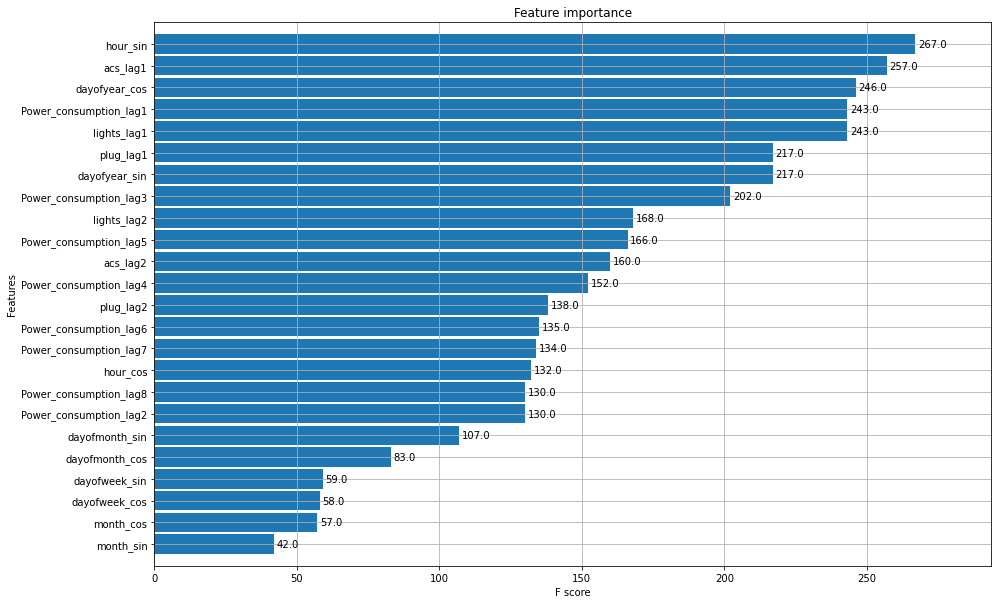

In [29]:
f, ax = plt.subplots(figsize=(15,10))
_ = plot_importance(reg, height=0.9,ax = ax)
plt.show()

In [30]:
df_test['Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

In [31]:
df_test[['Power_consumption','Prediction']]

,Power_consumption,Prediction
Date,,
2019-07-31 00:01:00,4.58,6.725935
2019-07-31 00:02:00,4.60,6.722601
2019-07-31 00:03:00,4.59,6.864047
2019-07-31 00:04:00,4.59,7.389406
2019-07-31 00:05:00,4.59,7.128199
...,...,...
2019-12-31 23:55:00,8.36,7.151307
2019-12-31 23:56:00,8.40,6.890100
2019-12-31 23:57:00,8.52,6.890100


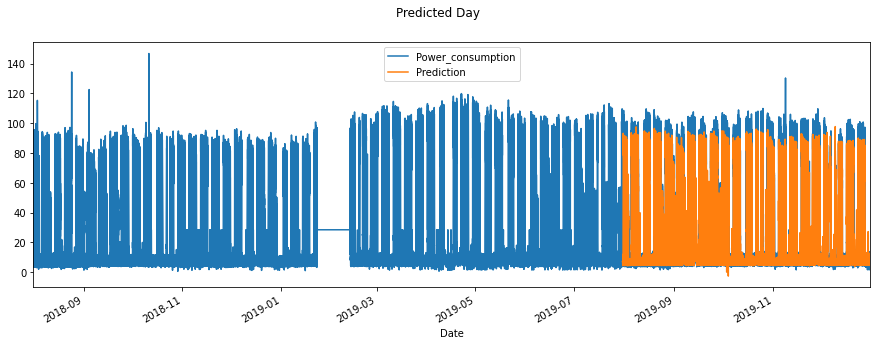

In [32]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['Power_consumption','Prediction']].plot(ax=ax,style=['-','-'])
ax.set_xbound(lower='08-01-2018', upper='12-31-2019')
plot = plt.suptitle('Predicted Day')
plt.show()

In [33]:
from sklearn import metrics
print ('MAE:', metrics.mean_absolute_error(df_test['Prediction'], df_test['Power_consumption']))
print ('MSE:', metrics.mean_squared_error(df_test['Prediction'], df_test['Power_consumption']))
print ('RSME:', np.sqrt(metrics.mean_absolute_error(df_test['Prediction'], df_test['Power_consumption'])))

MAE: 3.716498563526221
MSE: 49.16237331695553
RSME: 1.9278222333831045


In [34]:
from sklearn.metrics import r2_score
Accuracy=r2_score(df_test['Prediction'], df_test['Power_consumption'])*100
print(" Accuracy of the model is %.2f" %Accuracy)

 Accuracy of the model is 94.85


In [35]:
df=df.resample('D').mean()
df

,z1_AC1(kW),z1_Light(kW),z1_Plug(kW),z1_S1(degC),z1_S1(RH%),z1_S1(lux),z2_AC1(kW),z2_AC2(kW),z2_AC3(kW),z2_AC4(kW),...,z3_Plug(kW),z3_S1(degC),z3_S1(RH%),z3_S1(lux),z4_AC1(kW),z4_Light(kW),z4_Plug(kW),z4_S1(degC),z4_S1(RH%),z4_S1(lux)
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-01,0.000000,0.011181,0.148569,28.956192,59.488984,3.516106,0.647590,0.829104,0.614056,0.697528,...,0.308646,29.732456,68.285964,1.624911,0.000000,0.000000,0.00000,NaN,NaN,NaN
2018-07-02,16.077833,4.752167,1.705139,25.655944,54.621617,41.750358,10.072688,0.414056,0.220486,0.256292,...,0.485264,29.059055,62.174695,2.545455,3.923000,1.186889,0.00000,NaN,NaN,NaN
2018-07-03,13.754271,4.849236,1.768806,25.185978,53.043077,41.935793,10.568188,0.196653,0.013382,0.015556,...,0.526590,28.725604,59.556212,2.571025,3.848014,1.132917,0.00000,NaN,NaN,NaN
2018-07-04,13.021611,4.898472,1.918333,25.346513,53.552275,45.675408,10.536125,0.469597,0.270382,0.305799,...,0.492743,28.761490,60.486356,2.699859,3.484625,1.197646,0.00000,NaN,NaN,NaN
2018-07-05,13.400868,4.908486,1.723681,25.227502,53.472641,44.204270,11.326944,0.531299,0.331132,0.377549,...,0.484375,28.525987,59.285811,2.375176,3.873375,1.031215,0.00000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,10.254542,4.058569,1.633931,23.709583,59.785807,41.179416,9.319604,0.481819,0.278354,0.316785,...,0.288097,26.683542,62.016131,3.700765,2.945549,0.881444,0.02116,22.088520,70.770570,20.974288
2019-12-28,0.000000,0.010646,0.179896,25.571766,60.436704,0.627260,0.518021,0.644500,0.431750,0.484986,...,0.235250,27.368755,60.584242,1.419332,0.000000,0.000000,0.00000,25.092011,67.039054,0.160903
2019-12-29,0.000000,0.316319,0.188861,26.414631,60.749986,7.501391,0.506333,0.681292,0.471986,0.520285,...,0.235160,27.711794,55.860334,2.561892,0.000000,0.048604,0.00000,26.041307,63.760619,0.310153


In [36]:
daily_df=pd.DataFrame(columns=['lights','acs','plug'])
daily_df

,lights,acs,plug


In [53]:
df.columns

Index(['z1_AC1(kW)', 'z1_Light(kW)', 'z1_Plug(kW)', 'z1_S1(degC)',
       'z1_S1(RH%)', 'z1_S1(lux)', 'z2_AC1(kW)', 'z2_AC2(kW)', 'z2_AC3(kW)',
       'z2_AC4(kW)', 'z2_AC5(kW)', 'z2_AC6(kW)', 'z2_AC7(kW)', 'z2_AC8(kW)',
       'z2_AC9(kW)', 'z2_AC10(kW)', 'z2_AC11(kW)', 'z2_AC12(kW)',
       'z2_AC13(kW)', 'z2_AC14(kW)', 'z2_Light(kW)', 'z2_Plug(kW)',
       'z2_S1(degC)', 'z2_S1(RH%)', 'z2_S1(lux)', 'z3_Light(kW)',
       'z3_Plug(kW)', 'z3_S1(degC)', 'z3_S1(RH%)', 'z3_S1(lux)', 'z4_AC1(kW)',
       'z4_Light(kW)', 'z4_Plug(kW)', 'z4_S1(degC)', 'z4_S1(RH%)',
       'z4_S1(lux)'],
      dtype='object')

In [37]:
daily_df['lights']=df['z1_Light(kW)']+df['z2_Light(kW)']+df['z3_Light(kW)']+df['z4_Light(kW)']
daily_df['acs']=df['z1_AC1(kW)']+df['z2_AC1(kW)']+df['z2_AC2(kW)']+df['z2_AC3(kW)']+df['z2_AC4(kW)']+df['z2_AC5(kW)']+df['z2_AC6(kW)']+df['z2_AC7(kW)']+df['z2_AC8(kW)']+df['z2_AC9(kW)']+df['z2_AC10(kW)']+df['z2_AC11(kW)']+df['z2_AC12(kW)']+df['z2_AC13(kW)']+df['z2_AC14(kW)']+df['z4_AC1(kW)']
daily_df['plug']=df['z1_Plug(kW)']+df['z2_Plug(kW)']+df['z3_Plug(kW)']+df['z4_Plug(kW)']

In [38]:
daily_df['Power_consumption']=daily_df['lights']+daily_df['acs']+daily_df['plug']
daily_df.head(5)

,lights,acs,plug,Power_consumption
Date,,,,
2018-07-01,0.091840,7.352958,0.525667,7.970465
2018-07-02,7.355410,34.890465,2.509278,44.755153
2018-07-03,7.417854,32.265833,2.619201,42.302889
2018-07-04,7.618875,31.681694,2.745785,42.046354
2018-07-05,7.505743,33.566118,2.498472,43.570333


In [39]:
def daily_lag(data, col, lagtime):
    for i in range(1,lagtime+1):
        if len(pd.Series(col)) == 1:
            data[col+"_lag"+str(i)] = data[col].shift(i*2)
        else:
            for col_j in col:
                data[col_j+"_lag"+str(i)] = data[col_j].shift(i*2)
    return data

In [40]:
# Create Time Series Features 

daily_df['date'] = daily_df.index

# newdf['hour'] = newdf['date'].dt.hour
# newdf = encode(newdf,'hour',24)

daily_df['dayofweek'] = daily_df['date'].dt.dayofweek
daily_df = encode(daily_df,'dayofweek',7)

daily_df['month'] = daily_df['date'].dt.month
daily_df = encode(daily_df,'month',12)

# newdf['year'] = newdf['date'].dt.year

daily_df['dayofyear'] = daily_df['date'].dt.dayofyear
daily_df = encode(daily_df,'dayofyear',365)

daily_df['dayofmonth'] = daily_df['date'].dt.day
daily_df = encode(daily_df,'dayofmonth',31)

#newdf['weekofyear'] = newdf['date'].dt.weekofyear

daily_df.drop('date',axis=1,inplace = True)

In [41]:
daily_df

,lights,acs,plug,Power_consumption,dayofweek_sin,dayofweek_cos,month_sin,month_cos,dayofyear_sin,dayofyear_cos,dayofmonth_sin,dayofmonth_cos
Date,,,,,,,,,,,,
2018-07-01,0.091840,7.352958,0.525667,7.970465,-0.781831,0.623490,-5.000000e-01,-0.866025,8.606997e-03,-0.999963,2.012985e-01,0.979530
2018-07-02,7.355410,34.890465,2.509278,44.755153,0.000000,1.000000,-5.000000e-01,-0.866025,-8.606997e-03,-0.999963,3.943559e-01,0.918958
2018-07-03,7.417854,32.265833,2.619201,42.302889,0.781831,0.623490,-5.000000e-01,-0.866025,-2.581844e-02,-0.999667,5.712682e-01,0.820763
2018-07-04,7.618875,31.681694,2.745785,42.046354,0.974928,-0.222521,-5.000000e-01,-0.866025,-4.302223e-02,-0.999074,7.247928e-01,0.688967
2018-07-05,7.505743,33.566118,2.498472,43.570333,0.433884,-0.900969,-5.000000e-01,-0.866025,-6.021328e-02,-0.998186,8.486443e-01,0.528964
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,6.310729,27.680146,2.151625,36.142500,-0.433884,-0.900969,-2.449294e-16,1.000000,-6.880243e-02,0.997630,-7.247928e-01,0.688967
2019-12-28,0.232903,5.852451,0.485222,6.570576,-0.974928,-0.222521,-2.449294e-16,1.000000,-5.161967e-02,0.998667,-5.712682e-01,0.820763
2019-12-29,0.747597,5.970542,0.499299,7.217437,-0.781831,0.623490,-2.449294e-16,1.000000,-3.442161e-02,0.999407,-3.943559e-01,0.918958


In [42]:
# adding lagging feature

# adding time lags of 2days as features

lagtime = 2
lag_feature = ['lights','acs', 'plug']
daily_df = daily_lag(daily_df, lag_feature, lagtime)

# adding time lags of 10 days as features

daily_df = daily_lag(daily_df, 'Power_consumption', 5) #lag time 10 days

daily_df.drop(lag_feature,axis=1,inplace = True)

daily_df.dropna(inplace=True)

In [43]:
split_date =pd.to_datetime( '2019-07-31')
daily_train = daily_df.loc[daily_df.index <= split_date].copy()
daily_train.shape

(357, 20)

In [44]:
#df_test = pd.DataFrame(newdf.loc[newdf.index > split_date]
daily_test = pd.DataFrame(daily_df.loc[daily_df.index > split_date])

daily_test.shape

(153, 20)

In [45]:
X_train, y_train = daily_train.iloc[:,1:],daily_train.iloc[:,0]
X_test, y_test = daily_test.iloc[:,1:],daily_test.iloc[:,0]

In [46]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

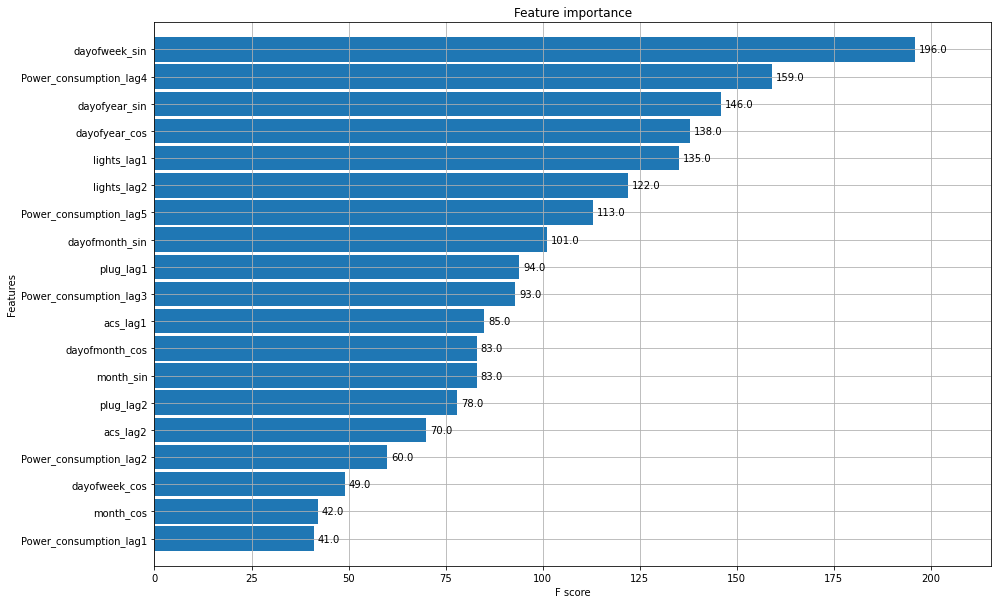

In [47]:
f, ax = plt.subplots(figsize=(15,10))
_ = plot_importance(reg, height=0.9,ax = ax)
plt.show()

In [48]:
daily_test['daily_Prediction'] = reg.predict(X_test)
daily_all = pd.concat([daily_test, daily_train], sort=False)

In [49]:
daily_test[['Power_consumption','daily_Prediction']]

,Power_consumption,daily_Prediction
Date,,
2019-08-01,37.815007,36.369064
2019-08-02,37.231764,36.263573
2019-08-03,14.481813,17.893255
2019-08-04,5.479500,7.551144
2019-08-05,38.512558,36.778580
...,...,...
2019-12-27,36.142500,31.465363
2019-12-28,6.570576,12.035889
2019-12-29,7.217437,7.000851


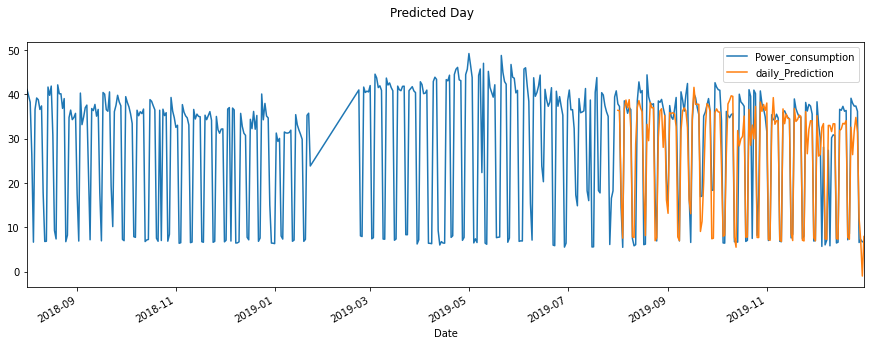

In [50]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = daily_all[['Power_consumption','daily_Prediction']].plot(ax=ax,style=['-','-'])
ax.set_xbound(lower='08-01-2018', upper='12-31-2019')
plot = plt.suptitle('Predicted Day')
plt.show()

In [51]:
from sklearn import metrics
print ('MAE:', metrics.mean_absolute_error(daily_test['daily_Prediction'], daily_test['Power_consumption']))
print ('MSE:', metrics.mean_squared_error(daily_test['daily_Prediction'], daily_test['Power_consumption']))
print ('RSME:', np.sqrt(metrics.mean_absolute_error(daily_test['daily_Prediction'], daily_test['Power_consumption'])))

MAE: 4.251150628816638
MSE: 44.54858738053821
RSME: 2.0618318624021303


In [52]:
from sklearn.metrics import r2_score
Accuracy=r2_score(daily_test['daily_Prediction'], daily_test['Power_consumption'])*100
print(" Accuracy of the model is %.2f" %Accuracy)

 Accuracy of the model is 70.45
